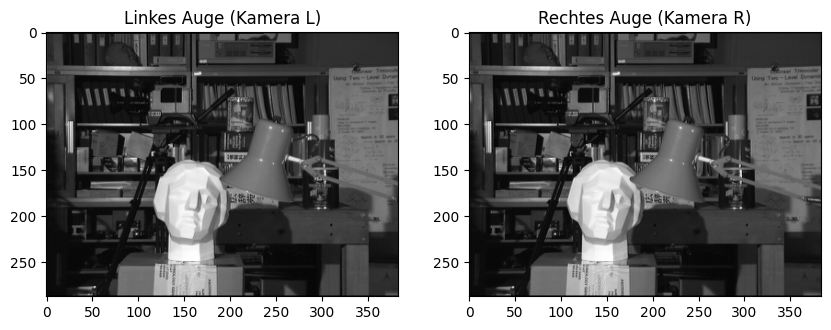

In [10]:
# Das Stereo-Paar laden

# Wir brauchen zwei Bilder, die exakt zum gleichen Zeitpunkt aus leicht versetzten Perspektiven aufgenommen wurden.

import cv2
import numpy as np
import matplotlib.pyplot as plt


imgL = cv2.imread('tsukuba_l.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('tsukuba_r.png', cv2.IMREAD_GRAYSCALE)

# Anzeigen
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(imgL, cmap='gray'); plt.title("Linkes Auge (Kamera L)")
plt.subplot(1, 2, 2); plt.imshow(imgR, cmap='gray'); plt.title("Rechtes Auge (Kamera R)")
plt.show()

# DISKUSSION:
# Schauen Sie auf die Lampe im Hintergrund und den Kopf im Vordergrund.
# Wo ist der Versatz größer? (Tipp: Vordergrund springt mehr!)

Berechne Disparität (Das Matching)...


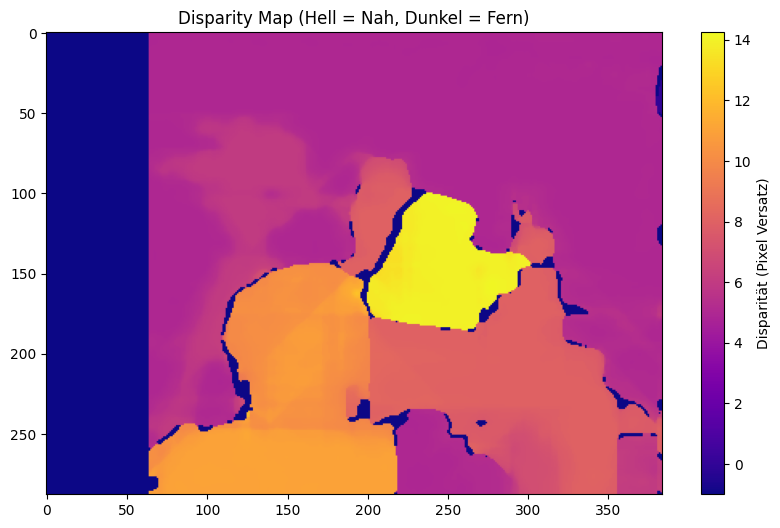

In [11]:
# Disparität berechnen (Stereo Matching)

# Wir nutzen StereoSGBM (Semi-Global Block Matching). Das ist viel robuster als einfaches Block Matching, da es glatte Oberflächen erzwingt.

# SGBM Parameter-Tuning (Das ist eine Kunst für sich!)
# minDisparity: Minimaler Versatz (meist 0)
# numDisparities: Wie weit darf der Pixel max. springen? (Muss durch 16 teilbar sein!)
# blockSize: Größe des Fensters, das verglichen wird (z.B. 5x5)

stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=64,  # Maximale Suche in Pixeln (Je größer, desto näher können Objekte sein)
    blockSize=11,       # Größeres Fenster = Glatter, aber verliert Details
    P1=8 * 3 * 11**2,   # Glättungs-Penalty 1
    P2=32 * 3 * 11**2,  # Glättungs-Penalty 2 (stärker)
    disp12MaxDiff=1,
    uniquenessRatio=10, # Filtert Pixel, die mehrdeutig sind
    speckleWindowSize=100,
    speckleRange=32
)

print("Berechne Disparität (Das Matching)...")
disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
# WICHTIG: OpenCV SGBM Output muss durch 16 geteilt werden, um echte Pixel-Werte zu erhalten!

# Visualisierung
plt.figure(figsize=(10, 6))
plt.imshow(disparity, cmap='plasma') # 'plasma' oder 'jet' ist gut für Tiefe
plt.colorbar(label='Disparität (Pixel Versatz)')
plt.title("Disparity Map (Hell = Nah, Dunkel = Fern)")
plt.show()

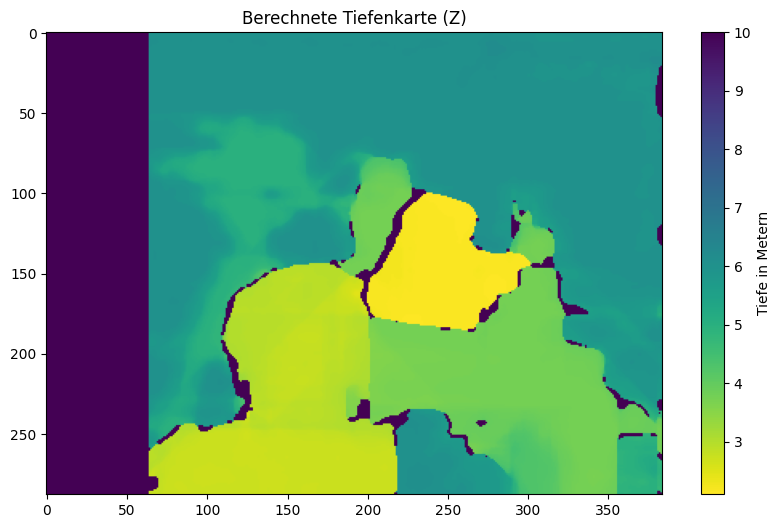

In [12]:
# Von Pixeln zu Metern (Die Tiefenformel)

# Jetzt wird es physikalisch. Wir wenden die Formel aus der Vorlesung an: Z = df * B​

#Da wir die echte Kamera nicht kalibriert haben, nehmen wir typische Werte an:

#    Brennweite (f): 500 Pixel (typisch für Webcams)
#    Basisabstand (B): 6 cm (0.06 m)

# Kameraparameter (Hypothetisch)
f = 500.0   # Brennweite in Pixel
B = 0.06    # Basisabstand in Metern (6 cm)

# Achtung: Division durch Null vermeiden!
# Wir setzen alle Disparitäten <= 0 auf einen sehr kleinen Wert (0.1)
disparity[disparity <= 0] = 0.1

# Berechnung der Tiefe Z (in Metern)
depth_map = (f * B) / disparity

# Visualisierung der echten Tiefe
plt.figure(figsize=(10, 6))
# Wir limitieren die Anzeige auf 2 Meter (vmax=2), sonst verzerren unendliche Punkte die Skala
plt.imshow(depth_map, cmap='viridis_r', vmax=10.0) # _r dreht die Farben um (Gelb=Nah)
plt.colorbar(label='Tiefe in Metern')
plt.title("Berechnete Tiefenkarte (Z)")
plt.show()

Analyse Punkt (180, 200):
 - Disparität: 10.38 Pixel (So weit ist der Punkt im rechten Bild gewandert)
 - Berechnete Tiefe: 2.89 Meter


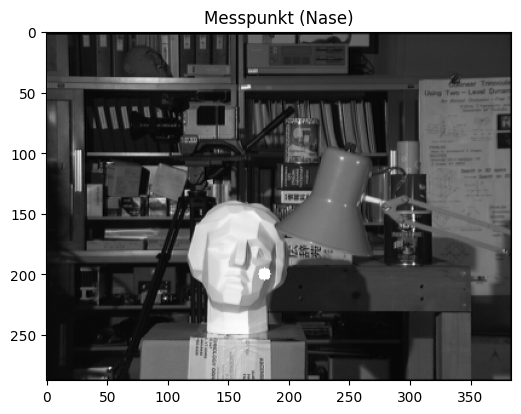

In [13]:
# Analyse eines Punktes (Interaktiv)
# Wir greifen uns einen Pixel (z.B. die Nase der Statue) und messen den Abstand.
# Wir wählen einen Punkt in der Bildmitte (Nase des Kopfes)
y_point, x_point = 200, 180

# Werte auslesen
disp_val = disparity[y_point, x_point]
depth_val = depth_map[y_point, x_point]

print(f"Analyse Punkt ({x_point}, {y_point}):")
print(f" - Disparität: {disp_val:.2f} Pixel (So weit ist der Punkt im rechten Bild gewandert)")
print(f" - Berechnete Tiefe: {depth_val:.2f} Meter")

# Punkt im Bild markieren
img_viz = imgL.copy()
cv2.circle(img_viz, (x_point, y_point), 5, (255), -1)

plt.figure(figsize=(6,6))
plt.imshow(img_viz, cmap='gray')
plt.title("Messpunkt (Nase)")
plt.show()

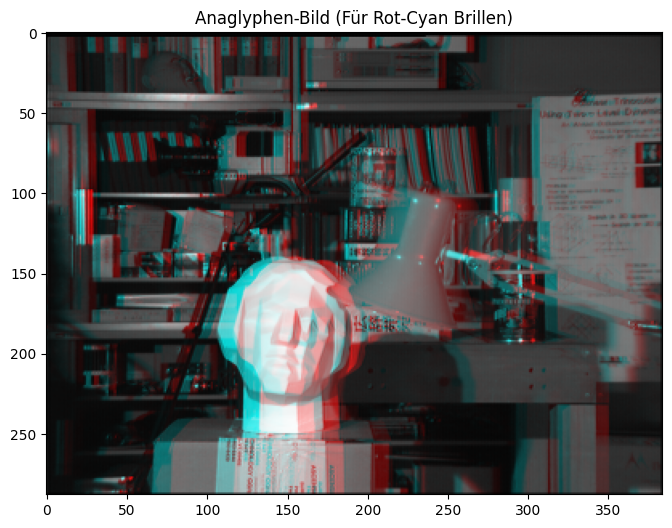

In [14]:
# "Poor Man's 3D" (Anaglyphe)
# Wenn Sie Rot-Cyan-Brillen hätten, könnten Sie das Bild jetzt in 3D sehen. Wir basteln ein Anaglyphen-Bild.

# Wir basteln ein 3D-Bild für Rot-Cyan Brillen
# Linkes Bild -> Rot Kanal
# Rechtes Bild -> Grün/Blau (Cyan) Kanal

height, width = imgL.shape
anaglyph = np.zeros((height, width, 3), dtype=np.uint8)

anaglyph[:, :, 0] = imgL # Rot Kanal bekommt Linkes Bild
anaglyph[:, :, 1] = imgR # Grün Kanal bekommt Rechtes Bild
anaglyph[:, :, 2] = imgR # Blau Kanal bekommt Rechtes Bild

plt.figure(figsize=(10, 6))
plt.imshow(anaglyph)
plt.title("Anaglyphen-Bild (Für Rot-Cyan Brillen)")
plt.show()

# Fragen zum Nachdenken

1. Das schwarze Loch: "Warum ist der Bereich ganz links im Disparitätsbild schwarz/leer?"

2. Rauschen: "Warum sind glatte Flächen (z.B. die Wand im Hintergrund) oft verrauscht oder lückenhaft?"

3. Physik: "Was passiert mit der Genauigkeit, wenn wir den Basisabstand (B) von 6cm auf 1 Meter vergrößern?"

# ACHTUNG: Spoiler

1. Verdeckung (Occlusion). Die linke Kamera sieht dort Dinge, die die rechte Kamera nicht sehen kann (weil die Nase/das Objekt die Sicht versperrt). Wo keine Daten in beiden Bildern sind, ist keine Berechnung möglich.

2. Textur-Mangel. Der Algorithmus sucht "Pixel X in Bild R". Wenn die Wand überall gleich weiß ist, findet er 100 mögliche Treffer und rät (oft falsch). Stereo Vision braucht Textur!

3. Wir können weiter entfernte Objekte genauer messen (Disparität wird größer), aber im Nahbereich verlieren wir die Überlappung (Blind Spot wird riesig).

Im Folgenden machen wir Parametereinstellen interaktiv.

In [15]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.4 MB/s eta 0:00:00


In [18]:
# Interaktives Tuning-Labor

#Der StereoSGBM Algorithmus hat viele Parameter.
# Falsche Einstellungen führen zu "Löchern" in der Wand oder "Geisterbildern".
# Wir bauen uns ein Dashboard, um die perfekte Einstellung für das Tsukuba-Bild zu finden.

import ipywidgets as widgets
from IPython.display import display

# Wir stellen sicher, dass die Bilder geladen sind (aus Schritt 1)
# imgL und imgR sollten Graustufenbilder sein

def update_stereo_map(num_disp, block_size, uniqueness, speckle_range):
    """
    Diese Funktion wird jedes Mal aufgerufen, wenn Sie einen Regler bewegen.
    """

    # Schutzmechanismus: BlockSize muss ungerade sein (3, 5, 7...)
    if block_size % 2 == 0:
        block_size += 1

    # Schutzmechanismus: NumDisparities muss durch 16 teilbar sein
    if num_disp % 16 != 0:
        num_disp = int(num_disp / 16) * 16
        if num_disp == 0: num_disp = 16

    # 1. Den Matcher mit neuen Parametern erstellen
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=num_disp,      # Suchbereich
        blockSize=block_size,         # Fenstergröße
        P1=8 * 3 * block_size**2,     # Glättung (klein)
        P2=32 * 3 * block_size**2,    # Glättung (stark)
        disp12MaxDiff=1,
        uniquenessRatio=uniqueness,   # Filtert mehrdeutige Pixel
        speckleWindowSize=100,        # Rauschentfernung (Größe)
        speckleRange=speckle_range    # Rauschentfernung (Toleranz)
    )

    # 2. Berechnen
    disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

    # 3. Plotten
    plt.figure(figsize=(12, 6))
    plt.imshow(disp, cmap='plasma')
    plt.colorbar(label='Disparität (Pixel)')
    plt.title(f"Live-Tuning: BlockSize={block_size}, NumDisp={num_disp}")
    plt.axis('off')
    plt.show()

# --- Das Dashboard bauen ---

style = {'description_width': 'initial'}

# Regler 1: NumDisparities (Wie weit darf der Pixel springen?)
# Muss durch 16 teilbar sein, wir setzen step=16
slider_num_disp = widgets.IntSlider(min=16, max=160, step=16, value=64,
                                    description='Suchbereich (NumDisp)', style=style)

# Regler 2: BlockSize (Wie groß ist das Vergleichsfenster?)
slider_block_size = widgets.IntSlider(min=3, max=25, step=2, value=11,
                                      description='Fenstergröße (BlockSize)', style=style)

# Regler 3: Uniqueness Ratio (Wie einzigartig muss der Match sein?)
slider_uniqueness = widgets.IntSlider(min=1, max=20, step=1, value=10,
                                      description='Filter (Uniqueness)', style=style)

# Regler 4: Speckle Range (Rauschunterdrückung)
slider_speckle = widgets.IntSlider(min=1, max=50, step=1, value=32,
                                   description='Glättung (SpeckleRange)', style=style)

# Interaktion starten
print("Bewegen Sie die Regler, um die Tiefenkarte zu optimieren!")
widgets.interact(update_stereo_map,
                 num_disp=slider_num_disp,
                 block_size=slider_block_size,
                 uniqueness=slider_uniqueness,
                 speckle_range=slider_speckle);

Bewegen Sie die Regler, um die Tiefenkarte zu optimieren!


interactive(children=(IntSlider(value=64, description='Suchbereich (NumDisp)', max=160, min=16, step=16, style…

# Aufgaben:

1. Stellen Sie BlockSize auf 3 (Minimum). Was passiert mit der Wand im Hintergrund?
2. Stellen Sie stufenweise die BlockSize auf 25 (Maximum). Was passiert dabei mit dem Bild?

3. Reduzieren Sie NumDisp auf 16 und gehen dann stufenweise auf 160. Was passiert dabei mit dem Bild?

In [17]:
# Der interaktive "Entfernungsmesser"

# Statt Koordinaten händisch einzutippen, bauen wir einen virtuellen Laser-Pointer.
# Wir nutzen Slider für X/Y-Koordinaten und zeigen ein Fadenkreuz im Bild an, das sofort die Distanz berechnet.

# Wir berechnen einmal eine "gute" Disparity Map als Basis
final_stereo = cv2.StereoSGBM_create(minDisparity=0, numDisparities=64, blockSize=11,
                                     P1=8*3*11**2, P2=32*3*11**2, uniquenessRatio=10)
final_disp = final_stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Kameraparameter (Annahme)
f = 500.0
B = 0.06

def measure_distance(x, y):
    # Grenzen checken
    h, w = final_disp.shape
    if x >= w: x = w - 1
    if y >= h: y = h - 1

    # Werte holen
    d_val = final_disp[y, x]

    # Tiefe berechnen (Schutz vor Div/0)
    if d_val <= 0.1:
        dist_m = float('inf')
        dist_text = "Unendlich / Fehler"
    else:
        dist_m = (f * B) / d_val
        dist_text = f"{dist_m:.2f} m"

    # Visualisierung: Fadenkreuz zeichnen
    img_cross = imgL.copy()
    # Farbe umwandeln für bunten Punkt (BGR -> RGB ist hier implizit für Matplotlib)
    img_cross = cv2.cvtColor(img_cross, cv2.COLOR_GRAY2RGB)

    # Fadenkreuz (Grün)
    cv2.line(img_cross, (x-20, y), (x+20, y), (0, 255, 0), 2)
    cv2.line(img_cross, (x, y-20), (x, y+20), (0, 255, 0), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_cross)
    plt.title(f"Messung an Pos ({x}, {y}): Disparität={d_val:.1f}px -> Distanz={dist_text}")
    plt.axis('off')
    plt.show()

# Slider für Koordinaten
h, w = imgL.shape
slider_x = widgets.IntSlider(min=0, max=w-1, step=5, value=w//2, description='X-Position')
slider_y = widgets.IntSlider(min=0, max=h-1, step=5, value=h//2, description='Y-Position')

widgets.interact(measure_distance, x=slider_x, y=slider_y);

interactive(children=(IntSlider(value=192, description='X-Position', max=383, step=5), IntSlider(value=144, de…